In [73]:
#LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
import xgboost
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy import stats
from scipy.stats import norm, skew
from imblearn.over_sampling import SMOTE,SVMSMOTE,KMeansSMOTE,SMOTENC,BorderlineSMOTE
from xgboost import XGBClassifier

In [74]:
%%time
train=pd.read_csv('D:/R/Pet Adoption/train.csv')
test=pd.read_csv('D:/R/Pet Adoption/test.csv')
print(train.shape,test.shape)

(18834, 11) (8072, 9)
Wall time: 47.9 ms


In [75]:
#####MISSING VALUE TREATMENT####

#OUTLIER HANDLER
def out_quant(x):
    d=np.arange(0,1,0.01)
    ds=x.quantile(d)
    return ds

train['condition']=train['condition'].fillna('3')
test['condition']=test['condition'].fillna('3')

In [76]:
train.head()

,pet_id,issue_date,listing_date,condition,color_type,length_m,height_cm,X1,X2,breed_category,pet_category
0,ANSL_69903,7/10/2016 0:00,9/21/2016 16:25,2,Brown Tabby,0.80,7.78,13,9,0,1
1,ANSL_66892,11/21/2013 0:00,12/27/2018 17:47,1,White,0.72,14.19,13,9,0,2
2,ANSL_69750,9/28/2014 0:00,10/19/2016 8:24,3,Brown,0.15,40.90,15,4,2,4
3,ANSL_71623,12/31/2016 0:00,1/25/2019 18:30,1,White,0.62,17.82,0,1,0,2
4,ANSL_57969,9/28/2017 0:00,11/19/2017 9:38,2,Black,0.50,11.06,18,4,0,1


In [77]:
# FEATURE ENGINEERING#

#1.
train['U_pet_id']=train['pet_id'].str.replace('ANSL_','').astype('int')
test['U_pet_id']=test['pet_id'].str.replace('ANSL_','').astype('int')


#2.
import time
def date_feat(train):
    train['IssYear'] = pd.to_datetime(train['issue_date']).dt.year
    train['IssMonth'] = pd.to_datetime(train['issue_date']).dt.month
    train['IssDay'] = pd.to_datetime(train['issue_date']).dt.day
    train['IssDayofweek'] = pd.to_datetime(train['issue_date']).dt.dayofweek
    train['IssDayOfyear'] = pd.to_datetime(train['issue_date']).dt.dayofyear
    train['IssWeekofyear']=pd.to_datetime(train['issue_date']).dt.weekofyear
    train['IssWeekDay']=pd.to_datetime(train['issue_date']).dt.weekday
    train['IssWeek'] = pd.to_datetime(train['issue_date']).dt.week
    train['IssQuarter'] = pd.to_datetime(train['issue_date']).dt.quarter 
    train['IssIs_month_start'] = pd.to_datetime(train['issue_date']).dt.is_month_start
    train['IssIs_month_end'] = pd.to_datetime(train['issue_date']).dt.is_month_end
    train['IssIs_quarter_start'] = pd.to_datetime(train['issue_date']).dt.is_quarter_start
    train['IssIs_quarter_end'] = pd.to_datetime(train['issue_date']).dt.is_quarter_end
    train['IssIs_year_start'] = pd.to_datetime(train['issue_date']).dt.is_year_start
    train['IssIs_year_end'] = pd.to_datetime(train['issue_date']).dt.is_year_end
    train['Semester_issue'] = np.where(train['issue_date'].isin([1,2]),1,2)
    train['Is_weekend_issue'] = np.where(train['issue_date'].isin([5,6]),1,0)
    train['Is_weekday_issue'] = np.where(train['issue_date'].isin([0,1,2,3,4]),1,0)
    train['Days_in_month_issue'] = pd.to_datetime(train['issue_date']).dt.days_in_month
    train['IssHour'] = pd.to_datetime(train['issue_date']).dt.hour
    return train


def dates_feats(test):
    test['IssYear'] = pd.to_datetime(test['issue_date']).dt.year
    test['IssMonth'] = pd.to_datetime(test['issue_date']).dt.month
    test['IssDay'] = pd.to_datetime(test['issue_date']).dt.day
    test['IssDayofweek'] = pd.to_datetime(test['issue_date']).dt.dayofweek
    test['IssDayOfyear'] = pd.to_datetime(test['issue_date']).dt.dayofyear
    test['IssWeekofyear']=pd.to_datetime(test['issue_date']).dt.weekofyear
    test['IssWeekDay']=pd.to_datetime(test['issue_date']).dt.weekday
    test['IssWeek'] = pd.to_datetime(test['issue_date']).dt.week
    test['IssQuarter'] = pd.to_datetime(test['issue_date']).dt.quarter 
    test['IssIs_month_start'] = pd.to_datetime(test['issue_date']).dt.is_month_start
    test['IssIs_month_end'] = pd.to_datetime(test['issue_date']).dt.is_month_end
    test['IssIs_quarter_start'] = pd.to_datetime(test['issue_date']).dt.is_quarter_start
    test['IssIs_quarter_end'] = pd.to_datetime(test['issue_date']).dt.is_quarter_end
    test['IssIs_year_start'] = pd.to_datetime(test['issue_date']).dt.is_year_start
    test['IssIs_year_end'] = pd.to_datetime(test['issue_date']).dt.is_year_end
    test['IssDays_in_month'] = pd.to_datetime(test['issue_date']).dt.days_in_month
    test['Semester_issue'] = np.where(test['issue_date'].isin([1,2]),1,2)
    test['Is_weekend_issue'] = np.where(test['issue_date'].isin([5,6]),1,0)
    test['Is_weekday_issue'] = np.where(test['issue_date'].isin([0,1,2,3,4]),1,0)
    test['Days_in_month_issue'] = pd.to_datetime(test['issue_date']).dt.days_in_month
    test['IssHour'] = pd.to_datetime(test['issue_date']).dt.hour
    return test


#####################
train=date_feat(train)
test=date_feat(test)
#####################


def list_feat(train):
    train['LssYear'] = pd.to_datetime(train['listing_date']).dt.year
    train['LssMonth'] = pd.to_datetime(train['listing_date']).dt.month
    train['LssDay'] = pd.to_datetime(train['listing_date']).dt.day
    train['LssDayofweek'] = pd.to_datetime(train['listing_date']).dt.dayofweek
    train['LssDayOfyear'] = pd.to_datetime(train['listing_date']).dt.dayofyear
    train['LssWeekofyear']=pd.to_datetime(train['listing_date']).dt.weekofyear
    train['LssWeekDay']=pd.to_datetime(train['listing_date']).dt.weekday
    train['LssWeek'] = pd.to_datetime(train['listing_date']).dt.week
    train['LssQuarter'] = pd.to_datetime(train['listing_date']).dt.quarter 
    train['LssIs_month_start'] = pd.to_datetime(train['listing_date']).dt.is_month_start
    train['LssIs_month_end'] = pd.to_datetime(train['listing_date']).dt.is_month_end
    train['LssIs_quarter_start'] = pd.to_datetime(train['listing_date']).dt.is_quarter_start
    train['LssIs_quarter_end'] = pd.to_datetime(train['listing_date']).dt.is_quarter_end
    train['LssIs_year_start'] = pd.to_datetime(train['listing_date']).dt.is_year_start
    train['LssIs_year_end'] = pd.to_datetime(train['listing_date']).dt.is_year_end
    train['Lss_Semester_arrival'] = np.where(train['listing_date'].isin([1,2]),1,2)
    train['Lss_weekend_arrival'] = np.where(train['listing_date'].isin([5,6]),1,0)
    train['Lss_weekday_arrival'] = np.where(train['listing_date'].isin([0,1,2,3,4]),1,0)
    train['Lss_Days_in_month_arrival'] = pd.to_datetime(train['listing_date']).dt.days_in_month
    train['LssHour'] = pd.to_datetime(train['listing_date']).dt.hour
    return train

def lists_feats(test):
    test['LssYear'] = pd.to_datetime(test['listing_date']).dt.year
    test['LssMonth'] = pd.to_datetime(test['listing_date']).dt.month
    test['LssDay'] = pd.to_datetime(test['listing_date']).dt.day
    test['LssDayofweek'] = pd.to_datetime(test['listing_date']).dt.dayofweek
    test['LssDayOfyear'] = pd.to_datetime(test['listing_date']).dt.dayofyear
    test['LssWeekofyear']=pd.to_datetime(test['listing_date']).dt.weekofyear
    test['LssWeekDay']=pd.to_datetime(test['listing_date']).dt.weekday
    test['LssWeek'] = pd.to_datetime(test['listing_date']).dt.week
    test['LssQuarter'] = pd.to_datetime(test['listing_date']).dt.quarter 
    test['LssIs_month_start'] = pd.to_datetime(test['listing_date']).dt.is_month_start
    test['LssIs_month_end'] = pd.to_datetime(test['listing_date']).dt.is_month_end
    test['LssIs_quarter_start'] = pd.to_datetime(test['listing_date']).dt.is_quarter_start
    test['LssIs_quarter_end'] = pd.to_datetime(test['listing_date']).dt.is_quarter_end
    test['LssIs_year_start'] = pd.to_datetime(test['listing_date']).dt.is_year_start
    test['LssIs_year_end'] = pd.to_datetime(test['listing_date']).dt.is_year_end
    test['Lss_Semester_arrival'] = np.where(test['listing_date'].isin([1,2]),1,2)
    test['Lss_weekend_arrival'] = np.where(test['listing_date'].isin([5,6]),1,0)
    test['Lss_weekday_arrival'] = np.where(test['listing_date'].isin([0,1,2,3,4]),1,0)
    test['Lss_Days_in_month_arrival'] = pd.to_datetime(test['listing_date']).dt.days_in_month
    test['LssHour'] = pd.to_datetime(test['listing_date']).dt.hour
    return test

#####################
train=list_feat(train)
test=lists_feats(test)
#####################

def diff_feat(train):
    train['DifYear'] = train['IssYear'] - train['LssYear']
    train['DifMonth'] = train['IssMonth'] - train['LssMonth']
    train['DifDay'] = train['IssDay'] - train['LssDay']
    train['DifDayofweek'] = train['IssDayofweek'] - train['LssDayofweek']
    train['DifDayOfyear'] = train['IssDayOfyear'] - train['LssDayOfyear']
    train['DifWeekofyear']= train['IssWeekofyear'] - train['LssWeekofyear']
    train['DifWeekDay']= train['IssWeekDay'] - train['LssWeekDay']
    train['DifWeek'] = train['IssWeek'] - train['LssWeek']
    train['DifQuarter'] = train['IssQuarter'] - train['LssQuarter']
    train['DifHour'] = train['IssHour'] - train['LssHour']
    return train
    
def diffs_feats(test):
    test['DifYear'] = test['LssYear'] - test['IssYear']
    test['DifMonth'] = test['LssMonth'] - test['IssMonth']
    test['DifDay'] = test['LssDay'] - test['IssDay']
    test['DifDayofweek'] = test['LssDayofweek'] - test['IssDayofweek']
    test['DifDayOfyear'] = test['LssDayOfyear'] -test['IssDayOfyear']
    test['DifWeekofyear']= test['LssWeekofyear'] - test['IssWeekofyear']
    test['DifWeekDay']= test['LssWeekDay'] - test['IssWeekDay']
    test['DifWeek'] = test['LssWeek'] - test['IssWeek']
    test['DifQuarter'] = test['LssQuarter'] - test['IssQuarter']
    test['DifHour'] = test['LssHour'] - test['IssHour']
    return test
    
    
#####################
train=diff_feat(train)
test=diffs_feats(test)    
#####################

#3.
###########################
train['length_m'] = train['length_m'] * 100
test['length_m']= test['length_m'] * 100
train['Area']=train['length_m'] * train['height_cm']
test['Area']=test['length_m'] * test['height_cm']
train['X3']=train['X1']+train['X2']
test['X3']=test['X1']+test['X2']

del train['issue_date']
del test['issue_date']
del train['listing_date']
del test['listing_date']

master = pd.concat([train.drop(['breed_category','pet_category'],axis=1),test])
master.head()

,pet_id,condition,color_type,length_m,height_cm,X1,X2,U_pet_id,IssYear,IssMonth,...,DifDay,DifDayofweek,DifDayOfyear,DifWeekofyear,DifWeekDay,DifWeek,DifQuarter,DifHour,Area,X3
0,ANSL_69903,2,Brown Tabby,80.0,7.78,13,9,69903,2016,7,...,-11,4,-73,-11,4,-11,0,-16,622.40,22
1,ANSL_66892,1,White,72.0,14.19,13,9,66892,2013,11,...,-6,0,-36,-5,0,-5,0,-17,1021.68,22
2,ANSL_69750,3,Brown,15.0,40.90,15,4,69750,2014,9,...,9,4,-22,-3,4,-3,-1,-8,613.50,19
3,ANSL_71623,1,White,62.0,17.82,0,1,71623,2016,12,...,6,1,341,48,1,48,3,-18,1104.84,1
4,ANSL_57969,2,Black,50.0,11.06,18,4,57969,2017,9,...,9,-3,-52,-7,-3,-7,-1,-9,553.00,22


In [78]:
master.LssIs_month_end.value_counts()

False    26002
True       904
Name: LssIs_month_end, dtype: int64

In [79]:
## SEPEARTION CATEGORY VS NUMERIC

continuous = []
cat = []

for i in master.columns:
    if master[i].dtype == "object":
        cat.append(i)
    else: continuous.append(i)

print("Continuous:", continuous)
print("-")
print("Categorical:", cat)

Continuous: ['length_m', 'height_cm', 'X1', 'X2', 'U_pet_id', 'IssYear', 'IssMonth', 'IssDay', 'IssDayofweek', 'IssDayOfyear', 'IssWeekofyear', 'IssWeekDay', 'IssWeek', 'IssQuarter', 'IssIs_month_start', 'IssIs_month_end', 'IssIs_quarter_start', 'IssIs_quarter_end', 'IssIs_year_start', 'IssIs_year_end', 'Semester_issue', 'Is_weekend_issue', 'Is_weekday_issue', 'Days_in_month_issue', 'IssHour', 'LssYear', 'LssMonth', 'LssDay', 'LssDayofweek', 'LssDayOfyear', 'LssWeekofyear', 'LssWeekDay', 'LssWeek', 'LssQuarter', 'LssIs_month_start', 'LssIs_month_end', 'LssIs_quarter_start', 'LssIs_quarter_end', 'LssIs_year_start', 'LssIs_year_end', 'Lss_Semester_arrival', 'Lss_weekend_arrival', 'Lss_weekday_arrival', 'Lss_Days_in_month_arrival', 'LssHour', 'DifYear', 'DifMonth', 'DifDay', 'DifDayofweek', 'DifDayOfyear', 'DifWeekofyear', 'DifWeekDay', 'DifWeek', 'DifQuarter', 'DifHour', 'Area', 'X3']
-
Categorical: ['pet_id', 'condition', 'color_type']


# EDA#

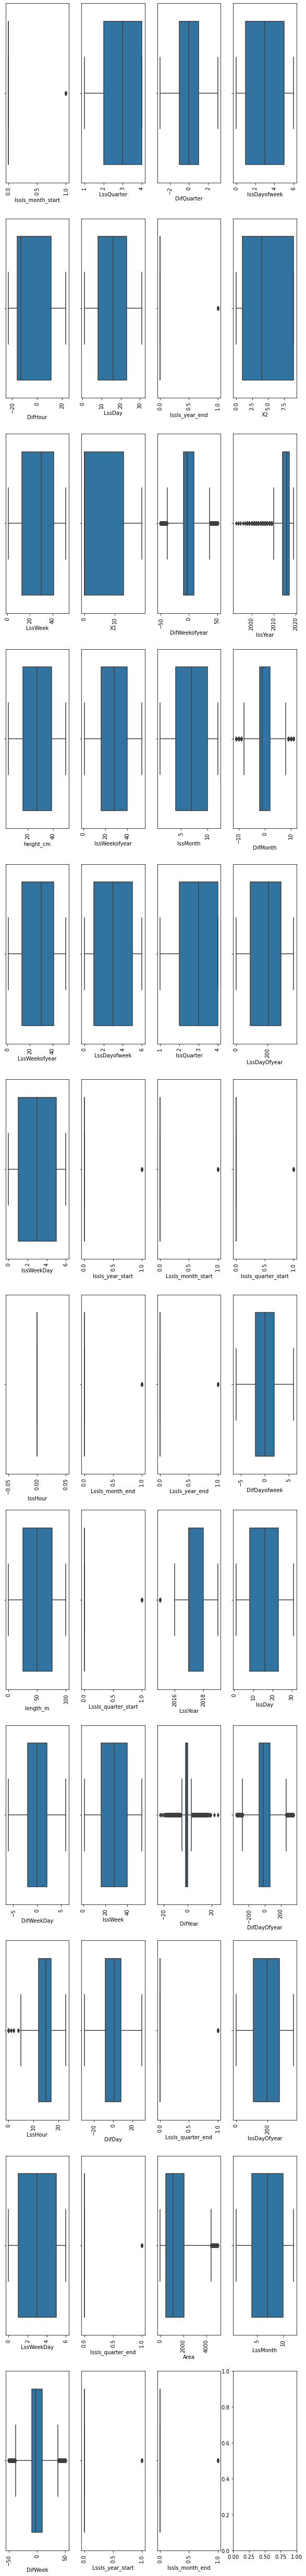

In [80]:
num={'length_m', 'height_cm', 'X1', 'X2','IssYear', 'IssMonth', 'IssDay', 'IssDayofweek', 'IssDayOfyear','IssWeekofyear', 
     'IssWeekDay', 'IssWeek', 'IssQuarter', 'IssIs_month_start', 'IssIs_month_end', 'IssIs_quarter_start',
     'IssIs_quarter_end', 'IssIs_year_start', 'IssIs_year_end', 'IssHour', 'LssYear', 'LssMonth', 'LssDay', 'LssDayofweek',
     'LssDayOfyear', 'LssWeekofyear', 'LssWeekDay', 'LssWeek', 'LssQuarter', 'LssIs_month_start', 'LssIs_month_end', 
     'LssIs_quarter_start', 'LssIs_quarter_end', 'LssIs_year_start', 'LssIs_year_end', 'LssHour', 'DifYear', 'DifMonth','DifDay',
     'DifDayofweek', 'DifDayOfyear', 'DifWeekofyear', 'DifWeekDay', 'DifWeek', 'DifQuarter', 'DifHour', 'Area'}
fig, ax=plt.subplots(12,4,figsize=(10,90))
for var,subplot in zip(num,ax.flatten()):
    sns.boxplot(master[var],ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

# VALUE COUNTS#

In [81]:
### VALUE COUNTS MULTIPLE COLUMN##
for i in train.columns:
    x=train[i].value_counts()
    print("Column name is:",i,"and it value is:",x)

Column name is: pet_id and it value is: ANSL_61657    1
ANSL_76441    1
ANSL_74186    1
ANSL_51343    1
ANSL_54803    1
             ..
ANSL_50836    1
ANSL_52448    1
ANSL_69774    1
ANSL_65589    1
ANSL_63512    1
Name: pet_id, Length: 18834, dtype: int64
Column name is: condition and it value is: 1.0    6819
0.0    6281
2.0    4257
3      1477
Name: condition, dtype: int64
Column name is: color_type and it value is: Black                4620
White                2453
Brown                1791
Brown Tabby          1687
Tan                  1349
Blue                  852
Orange Tabby          791
Red                   526
Brown Brindle         496
Tricolor              469
Blue Tabby            386
Tortie                366
Calico                343
Gray                  307
Chocolate             259
Torbie                242
Cream Tabby           191
Sable                 167
Cream                 162
Fawn                  159
Yellow                143
Buff                  125
Lynx 

# LABEL ENCDOING#

In [82]:

ds={'color_type','IssIs_month_start', 'IssIs_month_end', 'IssIs_quarter_start', 'IssIs_quarter_end','Lss_weekday_arrival',
    'IssIs_year_start', 'IssIs_year_end','LssIs_month_start', 'LssIs_month_end', 'LssIs_quarter_start',
    'LssIs_quarter_end', 'LssIs_year_start', 'LssIs_year_end','Lss_Semester_arrival','Lss_weekend_arrival',
    'Lss_Days_in_month_arrival','Semester_issue','Is_weekend_issue','Is_weekday_issue','Days_in_month_issue','condition',
   }



for i in ds:
    master[i]=master[i].astype(str)


for col in ds:
    lbl_enc = LabelEncoder() 
    master[col] = lbl_enc.fit_transform(master[col])
    
master = pd.get_dummies(master, columns=ds)      

In [83]:
master=master.drop(['pet_id'],axis=1)
master.head()

,length_m,height_cm,X1,X2,U_pet_id,IssYear,IssMonth,IssDay,IssDayofweek,IssDayOfyear,...,color_type_55,LssIs_quarter_end_0,LssIs_quarter_end_1,IssIs_quarter_end_0,IssIs_quarter_end_1,Is_weekday_issue_0,LssIs_year_start_0,LssIs_year_start_1,IssIs_month_end_0,IssIs_month_end_1
0,80.0,7.78,13,9,69903,2016,7,10,6,192,...,0,1,0,1,0,1,1,0,1,0
1,72.0,14.19,13,9,66892,2013,11,21,3,325,...,0,1,0,1,0,1,1,0,1,0
2,15.0,40.90,15,4,69750,2014,9,28,6,271,...,0,1,0,1,0,1,1,0,1,0
3,62.0,17.82,0,1,71623,2016,12,31,5,366,...,0,1,0,0,1,1,1,0,0,1
4,50.0,11.06,18,4,57969,2017,9,28,3,271,...,0,1,0,1,0,1,1,0,1,0


# TARGET VARIABLES#

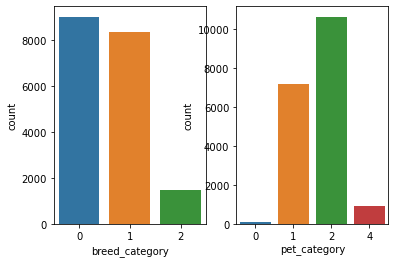

In [84]:
fig, ax =plt.subplots(1,2)
sns.countplot(train['breed_category'], ax=ax[0])
sns.countplot(train['pet_category'], ax=ax[1])
fig.show()

# MODEL BUILDING#

In [85]:
X_tr, y_tr,z_tr = master.iloc[:len(train)], train['breed_category'],train['pet_category']
X_trs=X_tr.copy()
X_test = master.iloc[len(train):]

X_tr.shape,y_tr.shape,X_test.shape,z_tr.shape

#SCALING#

sc = StandardScaler()
X_tr = sc.fit_transform(X_tr)
X_trs = sc.fit_transform(X_trs)
X_test = sc.transform(X_test)

In [86]:
#SMOTE#
sm_pet=SMOTE(sampling_strategy={0:941})
sm_breed=SMOTE(sampling_strategy={2:1500})
X_trs,z_tr = sm_pet.fit_resample(X_trs,z_tr)
X_tr,y_tr = sm_breed.fit_resample(X_tr,y_tr)

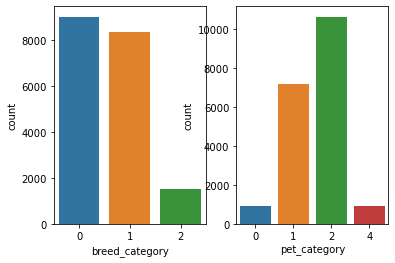

In [87]:
fig, ax =plt.subplots(1,2)
sns.countplot(y_tr, ax=ax[0])
sns.countplot(z_tr, ax=ax[1])
fig.show()

In [88]:
#SPLITTING#
x_train, x_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2)
x_trains, x_vals, z_trains, z_vals = train_test_split(X_trs, z_tr, test_size=0.2)

# MODEL1#

In [89]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
folds = 5
param_comb = 5

classifier1 = XGBClassifier(objective="multi:softmax")

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search_1 = RandomizedSearchCV(classifier1, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   n_jobs=-1, 
                                   cv=skf.split(x_train,y_train),
                                   verbose=3,scoring="f1_micro",
                                   random_state=1001 )

random_search_1.fit(x_train,y_train)
random_search_1.score(x_train,y_train)

#Prediction#
y_pred_1 = random_search_1.predict(x_val) 
print(accuracy_score(y_val,y_pred_1))
print(classification_report(y_val, y_pred_1))
f1 = f1_score(y_val,y_pred_1,average='weighted')
print(f1)
#Test Prediction#
test1 = random_search_1.predict(X_test) 
test1 = np.array(test1).flatten()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  1.1min remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished


0.9042948038176034
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1826
           1       0.91      0.87      0.89      1638
           2       1.00      1.00      1.00       308

    accuracy                           0.90      3772
   macro avg       0.93      0.93      0.93      3772
weighted avg       0.90      0.90      0.90      3772

0.9041473104265945


# MODEL2#

In [72]:

params = {        
          'min_child_weight': [1,2,3,4 ,5,6,7,8,9,10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1,2,3, 4, 5],
          }

folds = 5
param_comb = 5
classifier2 = XGBClassifier(objective="multi:softmax")
                      
skf = StratifiedKFold(n_splits=folds,shuffle = True,random_state = 1001)


random_search = RandomizedSearchCV(classifier2, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   n_jobs=-1, 
                                   cv=skf.split(X_trs,z_tr),
                                   verbose=3,
                                   random_state=1001 )

random_search.fit(X_trs,z_tr)
random_search.score(X_trs,z_tr)


#Prediction#
y_pred_2 = random_search.predict(x_vals) 
print(accuracy_score(z_vals,y_pred_2))
print(classification_report(z_vals, y_pred_2))
f1 = f1_score(z_vals,y_pred_2,average='weighted')
print(f1)

#Test Prediction#
test2 = random_search.predict(X_test) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 10.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 13.4min finished


0.9461655662772981
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       184
           1       0.95      0.91      0.93      1444
           2       0.93      0.97      0.95      2130
           4       0.98      0.90      0.94       180

    accuracy                           0.95      3938
   macro avg       0.96      0.94      0.95      3938
weighted avg       0.95      0.95      0.95      3938

0.945956666564616


In [76]:
#CATBOOST#
from sklearn.model_selection import RepeatedStratifiedKFold
K = 5
rskf =  StratifiedKFold(n_splits=K, shuffle = True, random_state = 1001)
score = []
resulted=[]
j=1
X_train_cv,y_train_cv = X_tr.copy(), z_tr.copy()
for i, (idxT, idxV) in enumerate(rskf.split(X_train_cv, y_train_cv)):
    print('Fold',i)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'
)    
    
    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
               early_stopping_rounds=50,verbose = 0)
    acc = f1_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1),average='weighted')
    score.append(acc)
    print ('CatBoost Val CV=',acc)
    print(confusion_matrix(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1)))
    print('#'*100)
    print('%.3f (%.3f)' % (np.array(score).mean(), np.array(score).std()))
    # Accumulate test set predictions
    rs = clf.predict(X_test)
    j = j + 1
    resulted.append(rs)
    # Average test set predictions

Fold 0
 rows of train = 15067 rows of holdout = 3767
CatBoost Val CV= 0.8702438081816708
[[   7    1    3    6    0]
 [   0 1235  200    2    0]
 [   0   67 2052    5    0]
 [   0    0    0    0    0]
 [   0    6   33  150    0]]
####################################################################################################
0.870 (0.000)
Fold 1
 rows of train = 15067 rows of holdout = 3767
CatBoost Val CV= 0.8630455536612324
[[   6    0    3    9    0]
 [   0 1231  197    9    0]
 [   0   94 2024    6    0]
 [   0    0    0    0    0]
 [   1    9   26  152    0]]
####################################################################################################
0.867 (0.004)
Fold 2
 rows of train = 15067 rows of holdout = 3767
CatBoost Val CV= 0.8580607722543184
[[   3    2    4    9    0]
 [   0 1194  237    6    0]
 [   0   73 2049    2    0]
 [   0    0    0    0    0]
 [   0    1   28  159    0]]
################################################################################

In [54]:
submission = pd.DataFrame()
submission['pet_id'] = test['pet_id']
submission['breed_category'] = test1
submission['pet_category'] = test2
submission.to_csv('submission_NeuralNetwork.csv',index=False)